In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt

from augmentation import rotate
from model import get_model
from preprocessing import min_max_normalize, resize_volume

In [2]:
def image_preprocessing(volume, min, max, desired_shape):
    volume = min_max_normalize(volume, min, max)
    # Resize width, height and depth
    volume = resize_volume(volume, desired_shape[0], desired_shape[1], desired_shape[2])
    return volume


def train_augmentation(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_augmentation(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [5]:
label_file_path = '/Users/jk1/stroke_research/SimpleVoxel-3D/leftright/labels.csv'
data_file_path = '/Users/jk1/stroke_research/SimpleVoxel-3D/leftright/data.npy'
desired_shape = (46, 46, 46)
split_ratio = 0.3
batch_size = 2
epochs = 20
initial_learning_rate = 0.0001

outcomes_df = pd.read_csv(label_file_path, index_col=0)
labels = np.array(outcomes_df).squeeze()

images = np.load(data_file_path)

images = np.array([image_preprocessing(image,  min=0, max=1, desired_shape=desired_shape) for image in images])

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=split_ratio, random_state=42,
                                                  shuffle=True, stratify=labels)

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
        .map(train_augmentation)
        .batch(batch_size)
        .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
        .map(validation_augmentation)
        .batch(batch_size)
        .prefetch(2)
)

In [13]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

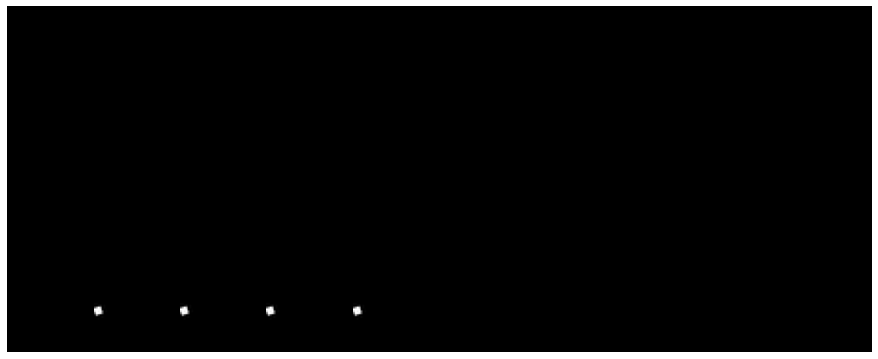

In [15]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 46, 46, image[:, :, :40])
